In [1]:
import torch, torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
mnist_trainset = torchvision.datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
mnist_testset = torchvision.datasets.MNIST(root='data', train=False, transform=ToTensor(), download=True)

In [4]:
mnist_trainset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

# Task 1
## Question a

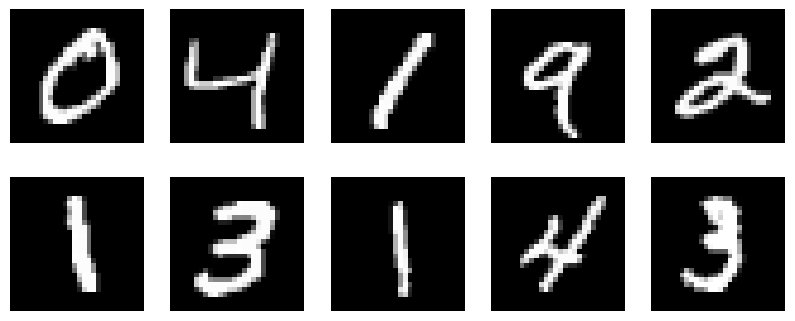

In [4]:
figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for idx in range(1, cols * rows + 1):
    img, label = mnist_trainset[idx]
    figure.add_subplot(rows, cols, idx)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Question b, c, d

In [34]:
def filter_and_limit_dataset(dataset, num_samples=None, labels_list=None):
    """
    Filters and limits the dataset to num_samples and maps the labels to 0 and 1.

    dataset: The dataset to filter (e.g., MNIST).
    num_samples: The number of samples to include in the filtered dataset.
    labels_list: A list or set of two labels to include in the dataset.
    """
    if labels_list is not None:
        label_to_binary_map = {label: idx for idx, label in enumerate(labels_list)}
        filtered_dataset = [(img, label_to_binary_map[label]) for img, label in dataset if label in labels_list]
    else:
        # Create a list from the entire dataset if no labels are specified
        filtered_dataset = list(dataset)

    if num_samples is not None:
        return filtered_dataset[:num_samples]
    return filtered_dataset

# Filter and limit the datasets
labels_01 = {0, 1}

mnist_trainset_01 = filter_and_limit_dataset(mnist_trainset, 200, labels_01)
mnist_testset_01 = filter_and_limit_dataset(mnist_testset, 2000, labels_01)

In [6]:
train_loader_01 = torch.utils.data.DataLoader(mnist_trainset_01, batch_size=64, shuffle=True)
val_loader_01 = torch.utils.data.DataLoader(mnist_testset_01, batch_size=64, shuffle=False)

In [7]:
class SimpleBinaryMLPSingle(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(784, 10)
        self.l2 = torch.nn.Linear(10, 10)
        self.l3 = torch.nn.Linear(10, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, image):
        flattened_image = image.view(-1, 784)
        x = self.sigmoid(self.l1(flattened_image))
        x = self.sigmoid(self.l2(x))
        x = self.sigmoid(self.l3(x))
        return x.squeeze()

In [8]:
class SimpleBinaryMLPMultiple(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(784, 10)
        self.l2 = torch.nn.Linear(10, 10)
        self.l3 = torch.nn.Linear(10, 2)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, image):
        flattened_image = image.view(-1, 784)
        x = self.sigmoid(self.l1(flattened_image))
        x = self.sigmoid(self.l2(x))
        x = self.sigmoid(self.l3(x))
        return x

In [9]:
model_01 = SimpleBinaryMLPSingle()
model_01.to(device)

SimpleBinaryMLPSingle(
  (l1): Linear(in_features=784, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=10, bias=True)
  (l3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
model_01(mnist_trainset_01[0][0].to(device))

tensor(0.4637, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [11]:
loss_fn = torch.nn.MSELoss()
optimizer_01 = torch.optim.Adam(params =  model_01.parameters(), lr=1e-05)

In [56]:
def train(model, epoch, dataloader, optimizer, loss_function):
    model.train()
    size = len(dataloader.dataset)
    for batch, (image, target) in enumerate(train_loader_01):
        image = image.to(device)
        target = target.to(device, dtype=torch.float)

        # For MSE Loss with SimpleBinaryMLPMultiple, convert target to one-hot format
        if isinstance(model, SimpleBinaryMLPMultiple):
            target = target.long()
            one_hot_labels = torch.nn.functional.one_hot(target, num_classes=2).float()

        outputs = model(image)

        # Compute loss
        if isinstance(model, SimpleBinaryMLPMultiple):
            loss = loss_function(outputs, one_hot_labels)
        else:
            loss = loss_function(outputs, target.float())  # Assuming target are 0 and 1


        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            current = (batch + 1) * len(target)
            print(f"Epoch: {epoch}, loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    print(f"Epoch: {epoch}, loss: {loss.item():>7f}  [{size:>5d}/{size:>5d}]")

In [13]:
for epoch in range(15):
    train(model_01, epoch, train_loader_01, optimizer_01, loss_fn)

Epoch: 0, loss: 0.256390  [   64/  200]
Epoch: 0, loss: 0.261082  [  200/  200]
Epoch: 1, loss: 0.253905  [   64/  200]
Epoch: 1, loss: 0.251827  [  200/  200]
Epoch: 2, loss: 0.262202  [   64/  200]
Epoch: 2, loss: 0.270231  [  200/  200]
Epoch: 3, loss: 0.249176  [   64/  200]
Epoch: 3, loss: 0.261011  [  200/  200]
Epoch: 4, loss: 0.256194  [   64/  200]
Epoch: 4, loss: 0.260599  [  200/  200]
Epoch: 5, loss: 0.253867  [   64/  200]
Epoch: 5, loss: 0.241926  [  200/  200]
Epoch: 6, loss: 0.249133  [   64/  200]
Epoch: 6, loss: 0.251514  [  200/  200]
Epoch: 7, loss: 0.254869  [   64/  200]
Epoch: 7, loss: 0.279498  [  200/  200]
Epoch: 8, loss: 0.250272  [   64/  200]
Epoch: 8, loss: 0.232860  [  200/  200]
Epoch: 9, loss: 0.252561  [   64/  200]
Epoch: 9, loss: 0.241790  [  200/  200]
Epoch: 10, loss: 0.254895  [   64/  200]
Epoch: 10, loss: 0.241801  [  200/  200]
Epoch: 11, loss: 0.257041  [   64/  200]
Epoch: 11, loss: 0.241923  [  200/  200]
Epoch: 12, loss: 0.254776  [   64/  

In [57]:
def validate(dataloader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient needed
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            if isinstance(model, SimpleBinaryMLPSingle):
                # For SimpleBinaryMLPSingle, use 0.5 threshold for binary classification
                predicted = outputs >= 0.5
            else: # isinstance(model, SimpleBinaryMLPMultiple):
                # For SimpleBinaryMLPMultiple, select the class with the higher score
                _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy


In [15]:
# Calculate accuracy on test data
test_accuracy = validate(val_loader_01, model_01)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 46.40%


In [16]:
# Filter and limit the datasets
labels_49 = [4, 9]

mnist_trainset_49 = filter_and_limit_dataset(mnist_trainset, 200, labels_49)
mnist_testset_49 = filter_and_limit_dataset(mnist_testset, 2000, labels_49)

train_loader_49 = torch.utils.data.DataLoader(mnist_trainset_01, batch_size=64, shuffle=True)
val_loader_49 = torch.utils.data.DataLoader(mnist_testset_01, batch_size=64, shuffle=False)

In [17]:
model_49 = SimpleBinaryMLPMultiple()
model_49.to(device)

SimpleBinaryMLPMultiple(
  (l1): Linear(in_features=784, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=10, bias=True)
  (l3): Linear(in_features=10, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
loss_fn = torch.nn.MSELoss()
optimizer_49 = torch.optim.Adam(params =  model_49.parameters(), lr=1e-05)

In [19]:
for epoch in range(100):
    train(model_49, epoch, train_loader_49, optimizer_49, loss_fn)

Epoch: 0, loss: 0.277226  [   64/  200]
Epoch: 0, loss: 0.291793  [  200/  200]
Epoch: 1, loss: 0.277033  [   64/  200]
Epoch: 1, loss: 0.264441  [  200/  200]
Epoch: 2, loss: 0.281700  [   64/  200]
Epoch: 2, loss: 0.245944  [  200/  200]
Epoch: 3, loss: 0.279343  [   64/  200]
Epoch: 3, loss: 0.273670  [  200/  200]
Epoch: 4, loss: 0.272508  [   64/  200]
Epoch: 4, loss: 0.291773  [  200/  200]
Epoch: 5, loss: 0.280411  [   64/  200]
Epoch: 5, loss: 0.264232  [  200/  200]
Epoch: 6, loss: 0.276971  [   64/  200]
Epoch: 6, loss: 0.273436  [  200/  200]
Epoch: 7, loss: 0.280263  [   64/  200]
Epoch: 7, loss: 0.282406  [  200/  200]
Epoch: 8, loss: 0.277891  [   64/  200]
Epoch: 8, loss: 0.264078  [  200/  200]
Epoch: 9, loss: 0.275667  [   64/  200]
Epoch: 9, loss: 0.300625  [  200/  200]
Epoch: 10, loss: 0.274410  [   64/  200]
Epoch: 10, loss: 0.282551  [  200/  200]
Epoch: 11, loss: 0.270866  [   64/  200]
Epoch: 11, loss: 0.282384  [  200/  200]
Epoch: 12, loss: 0.273266  [   64/  

In [20]:
# Calculate accuracy on test data
test_accuracy = validate(val_loader_49, model_49)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 46.40%


## Question e

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def prepare_data_for_lda(dataset):
    images = [img.numpy().reshape(-1) for img, _ in dataset]
    labels = [label for _, label in dataset]
    return np.array(images), np.array(labels)

# Prepare data
X_train_01, y_train_01 = prepare_data_for_lda(mnist_trainset_01)
X_test_01, y_test_01 = prepare_data_for_lda(mnist_testset_01)

X_train_49, y_train_49 = prepare_data_for_lda(mnist_trainset_49)
X_test_49, y_test_49 = prepare_data_for_lda(mnist_testset_49)


In [22]:
# Train LDA model for 0 and 1
lda_01 = LinearDiscriminantAnalysis()
lda_01.fit(X_train_01, y_train_01)

# Train LDA model for 4 and 9
lda_49 = LinearDiscriminantAnalysis()
lda_49.fit(X_train_49, y_train_49)


LinearDiscriminantAnalysis()

In [23]:
# Evaluate LDA model on test data
y_pred_01 = lda_01.predict(X_test_01)
accuracy_01 = 100 * accuracy_score(y_test_01, y_pred_01)
print(f"LDA Accuracy for 0 and 1: {accuracy_01:.2f}%")

y_pred_49 = lda_49.predict(X_test_49)
accuracy_49 = 100 * accuracy_score(y_test_49, y_pred_49)
print(f"LDA Accuracy for 4 and 9: {accuracy_49:.2f}%")


LDA Accuracy for 0 and 1: 99.35%
LDA Accuracy for 4 and 9: 89.65%


# Task 2


In [45]:
class ConvNet(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.feature_extractor = torch.nn.Sequential(            
            torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=12, out_channels=n_classes, kernel_size=4, stride=1),
            torch.nn.ReLU()
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        logits = torch.flatten(x, 1)
        # logits = self.classifier(x)
        # probs = torch.nn.functional.softmax(logits, dim=1)
        return logits#, probs

In [46]:
model_conv = ConvNet(10)
model_conv.to(device)

ConvNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(12, 10, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
  )
)

In [47]:
# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-4)

In [48]:
mnist_trainset_1000 = filter_and_limit_dataset(mnist_trainset, 1000)

train_loader_1000 = torch.utils.data.DataLoader(mnist_trainset_1000, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)

In [52]:
def train_conv(model, epoch, dataloader, optimizer, loss_function):
    model.train()
    size = len(dataloader.dataset)
    for batch, (image, target) in enumerate(dataloader):
        image = image.to(device)
        # Target for CrossEntropyLoss should be of long type and not one-hot encoded
        target = target.to(device, dtype=torch.long)

        # Forward pass
        outputs = model(image)

        # Compute loss
        loss = loss_function(outputs, target)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            current = (batch + 1) * len(target)
            print(f"Epoch: {epoch}, batch_loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    print(f"Epoch: {epoch}, batch_loss: {loss.item():>7f}  [{size:>5d}/{size:>5d}]")


In [61]:

# Train the model
for epoch in range(10):
    train_conv(model_conv, epoch, train_loader_1000, optimizer, loss_fn)

Epoch: 0, batch_loss: 1.241809  [   64/ 1000]
Epoch: 0, batch_loss: 0.985205  [ 1000/ 1000]
Epoch: 1, batch_loss: 1.153422  [   64/ 1000]
Epoch: 1, batch_loss: 1.214937  [ 1000/ 1000]
Epoch: 2, batch_loss: 1.373251  [   64/ 1000]
Epoch: 2, batch_loss: 1.053423  [ 1000/ 1000]
Epoch: 3, batch_loss: 1.157856  [   64/ 1000]
Epoch: 3, batch_loss: 0.813568  [ 1000/ 1000]
Epoch: 4, batch_loss: 1.272192  [   64/ 1000]
Epoch: 4, batch_loss: 1.118268  [ 1000/ 1000]
Epoch: 5, batch_loss: 1.282182  [   64/ 1000]
Epoch: 5, batch_loss: 1.099139  [ 1000/ 1000]
Epoch: 6, batch_loss: 1.018999  [   64/ 1000]
Epoch: 6, batch_loss: 1.160407  [ 1000/ 1000]
Epoch: 7, batch_loss: 1.429004  [   64/ 1000]
Epoch: 7, batch_loss: 1.154202  [ 1000/ 1000]
Epoch: 8, batch_loss: 0.991560  [   64/ 1000]
Epoch: 8, batch_loss: 1.267465  [ 1000/ 1000]
Epoch: 9, batch_loss: 1.199132  [   64/ 1000]
Epoch: 9, batch_loss: 1.157305  [ 1000/ 1000]


In [62]:
test_accuracy_conv = validate(val_loader, model_conv)
print(f'Test Accuracy ConvNet: {test_accuracy_conv:.2f}%')


Test Accuracy ConvNet: 53.78%
